Lasso had the best accuracy score, with an adjusted R-squared of 91%. General living area, overall quality, lot area, and certain types of neighborhoods had the greatest correlation with a higher sale price, while the 'ClyTile' roof material and certain sales conditions ('Abnormal' & 'Family) are associated with lower sale prices.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import stats

# import methods needed for modeling
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score

In [185]:
data = pd.read_csv('data_norm.csv')

In [121]:
# Isolate outcome variable
saleprice = data['SalePrice']

In [69]:
saleprice.describe()

count    1191.000000
mean       12.084323
std         0.385904
min        10.460271
25%        11.831386
50%        12.072547
75%        12.328295
max        13.534474
Name: SalePrice, dtype: float64

In [6]:
data['HasBsmt'].value_counts() # all houses in our data have a basement

1    1191
Name: HasBsmt, dtype: int64

In [11]:
data['HasPorch'].value_counts() # all houses in our data have a porch`

1    1191
Name: HasPorch, dtype: int64

In [ ]:
# Isolate predictors
data = data.drop(['Id', 'SalePrice', 'Unnamed: 0', 'HasBsmt', 'HasPorch'], axis=1)

In [123]:
# One Hot Encoding
data = pd.get_dummies(data, columns=['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 
                                            'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                                            'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                                            'Heating', 'Functional', 'GarageType', 
                                            'GarageFinish', 'PavedDrive', 'SaleType', 'Electrical', 'SaleCondition'])

(array([   2.,    4.,   35.,  114.,  350.,  367.,  208.,   87.,   18.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

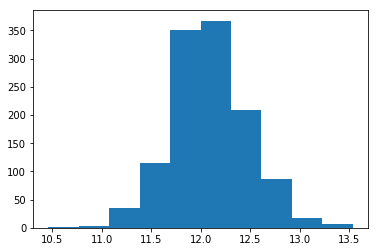

In [74]:
plt.hist(saleprice)

In [124]:
# Split the data into training sets and test sets
x_train, x_test, y_train, y_test = train_test_split(data, saleprice, test_size = 0.25, random_state = 0)

In [14]:
# Make RMSE the scorer
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_train(model):
    return np.sqrt(-cross_val_score(model, x_train, y_train, scoring=scorer, cv=10))

def rmse_test(model):
    return np.sqrt(-cross_val_score(model, x_test, y_test, scoring=scorer, cv=10))

### Linear Regression Without Regularization

In [125]:
# Initialize Linear Reg
lr = LinearRegression()
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

In [126]:
# What is RMSE for both training and test set?
print("Training set RMSE is: " +str(rmse_train(lr).mean())) 
print("Test set RMSE is: "+str(rmse_test(lr).mean()))

Training set RMSE is: 0.150067187957
Test set RMSE is: 0.170157691828


In [29]:
# Calculate adjusted R-squared
def adj_rsquared(rsquared, data):
    n = data.shape[0]
    p = data.shape[1]
    a = ((1-rsquared)*(n-1))/(n-p-1)
    return 1 - a

In [127]:
r2_test = r2_score(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)

In [128]:
r2_test

0.91451231020300183

In [129]:
adj_rsquared(r2_test, data)

0.89523135853920921

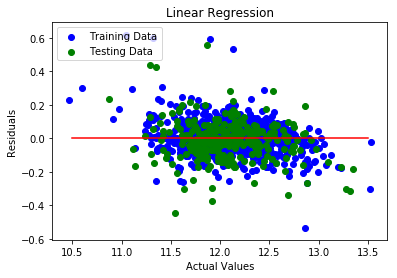

In [130]:
# Plot residuals
plt.scatter(y_train, (y_train_pred - y_train), c="blue", marker = "o", label="Training Data")
plt.scatter(y_test, (y_test_pred - y_test), c="green", marker = "o", label = "Testing Data")
plt.title("Linear Regression")
plt.xlabel("Actual Values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [0, 0], c = "red")
plt.show()

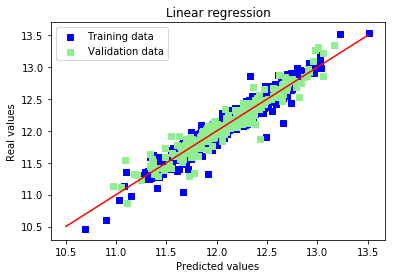

In [131]:
# Plot predictions - how closely did predictions match actual results?
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
#plt.xlim(-0.5, 0.5)
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

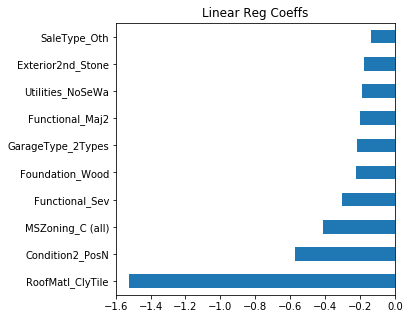

In [132]:
# Which coefficients were most important in predicting Sales Price?
coef = pd.Series(lr.coef_,index=x_test.columns).sort_values()[0:10]
coef.plot(kind="barh", title = "Linear Reg Coeffs", figsize=(5, 5))

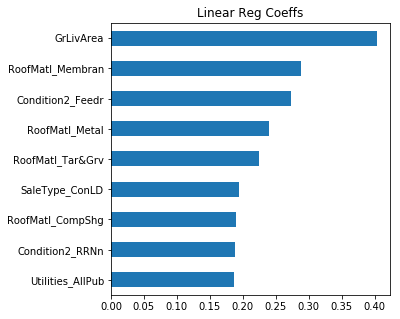

In [133]:
# Which coefficients were most important in predicting Sales Price?
coef = pd.Series(lr.coef_,index=x_test.columns).sort_values()[-10:-1]
coef.plot(kind="barh", title = "Linear Reg Coeffs", figsize=(5, 5))

### Ridge Regularization

In [134]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(x_train, y_train)
alpha = ridge.alpha_

y_rdg_pred_train = ridge.predict(x_train)
y_rdg_pred_test = ridge.predict(x_test)

In [105]:
rmse_test(ridge).mean()

0.11963800632165533

In [106]:
r2_rdg_test = r2_score(y_test, y_rdg_pred_test)

In [110]:
r2_rdg_test

0.92454089052047539

In [109]:
adj_rsquared(r2_rdg_test, data)

0.90733091818304001

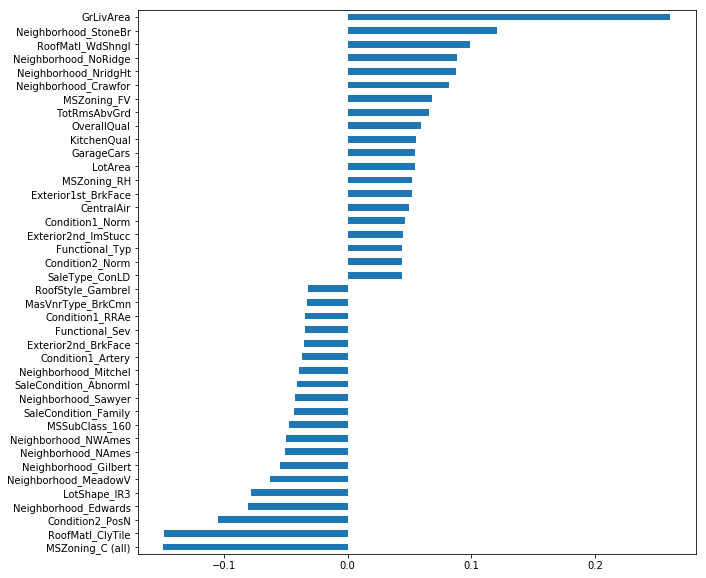

In [135]:
# What are the coefficients with most weight?
coefs = pd.Series(ridge.coef_, index=x_train.columns)
import_coefs = pd.concat([coefs.sort_values().head(20), coefs.sort_values().tail(20)])
import_coefs.plot(kind='barh', figsize=(10, 10))

Certain neighborhoods increase the value of the home, and certain neighborhoods decrease it. General living area, overall quality, kitchen quality, number of cars that can fit in the garage, and lot area all contribute to a higher sale price

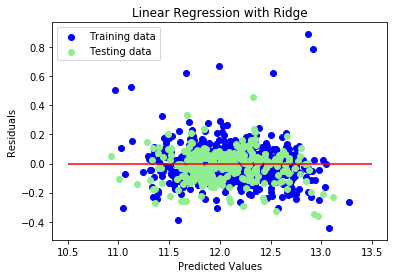

In [115]:
# What do residuals look like?
plt.scatter(y_rdg_pred_train, (y_rdg_pred_train - y_train), c="blue", marker="o", label = "Training data")
plt.scatter(y_rdg_pred_test, (y_rdg_pred_test - y_test), c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Ridge")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

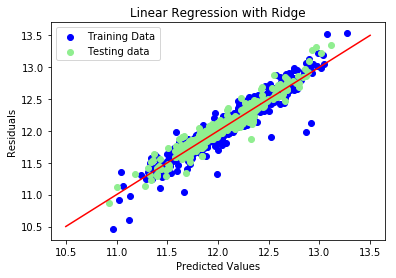

In [116]:
# How does prediction compare to actual data?
plt.scatter(y_rdg_pred_train, y_train, c="blue", marker="o", label="Training Data")
plt.scatter(y_rdg_pred_test, (y_test), c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Ridge")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], color = "red")
plt.show()

In [136]:
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")

Ridge picked 216 features and eliminated the other 3 features


In [137]:
#Which features were eliminated?
coefs[coefs == 0]

Condition2_PosA     0.0
Condition2_RRAe     0.0
Electrical_FuseP    0.0
dtype: float64

### Lasso

In [143]:
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1, 3, 6, 10, 30, 60], 
                max_iter = 50000, cv = 10)

lasso.fit(x_train, y_train)
alpha_lasso = lasso.alpha_

lasso2 = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)

lasso2.fit(x_train, y_train)
alpha_lasso2 = lasso2.alpha_

y_train_lass = lasso.predict(x_train)
y_test_lass = lasso.predict(x_test)

y_train_lass2 = lasso2.predict(x_train)
y_test_lass2 = lasso2.predict(x_test)

In [156]:
rmse_test(lasso2).mean()

0.29017706362573253

In [157]:
r2_score(y_test, y_test_lass2)

0.43051505157231751

In [146]:
adj_rsquared(r2_score(y_test, y_test_lass2), data)

0.30207302921839119

In [147]:
mean_squared_error(y_test, y_test_lass2)

0.090311978790497266

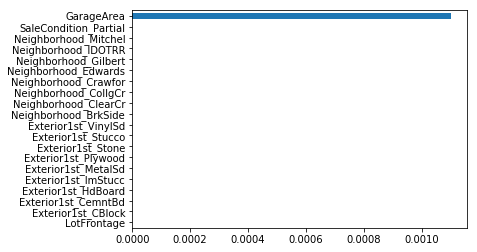

In [165]:
# What are the important coefficients?
coefs_lasso = pd.Series(lasso2.coef_, index=x_train.columns)
import_coefs_lasso = pd.concat([coefs_lasso.sort_values().head(10), coefs_lasso.sort_values().tail(10)])
import_coefs_lasso.plot(kind='barh')

In [153]:
coefs_lasso[coefs_lasso!=0] # For some reason lasso only identified GarageArea as a predictor

GarageArea    0.0011
dtype: float64

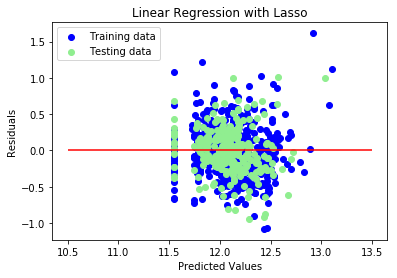

In [169]:
# What do residuals look like?
plt.scatter(y_train_lass2, (y_train_lass2 - y_train), c="blue", marker="o", label = "Training data")
plt.scatter(y_test_lass2, (y_test_lass2 - y_test), c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Lasso")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

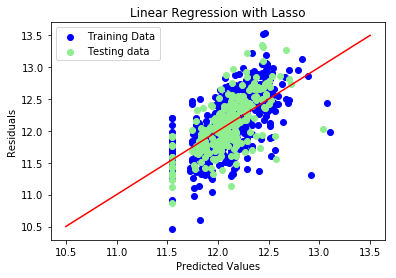

In [170]:
# How does prediction compare to actual data?
plt.scatter(y_train_lass2, y_train, c="blue", marker="o", label="Training Data")
plt.scatter(y_test_lass2, y_test, c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Lasso")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], color = "red")
plt.show()

In [159]:
# Let's try lasso without the further tuning
rmse_test(lasso).mean()

0.10839920575185266

In [160]:
r2_score(y_test, y_test_lass)

0.93063530433235908

In [161]:
adj_rsquared(r2_score(y_test, y_test_lass), data)

0.91499074372348843

In [163]:
mean_squared_error(y_test, y_test_lass)

0.011000225627105923

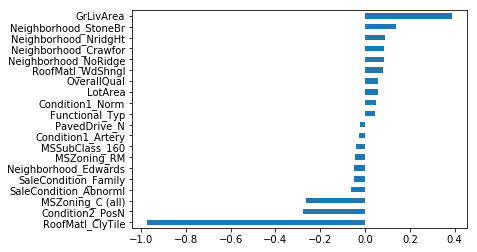

In [166]:
# What are the important coefficients?
coefs_lasso = pd.Series(lasso.coef_, index=x_train.columns)
import_coefs_lasso = pd.concat([coefs_lasso.sort_values().head(10), coefs_lasso.sort_values().tail(10)])
import_coefs_lasso.plot(kind='barh')

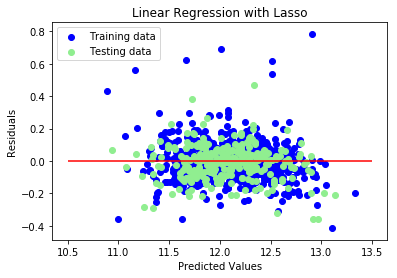

In [167]:
# What do residuals look like?
plt.scatter(y_train_lass, (y_train_lass - y_train), c="blue", marker="o", label = "Training data")
plt.scatter(y_test_lass, (y_test_lass - y_test), c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Lasso")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

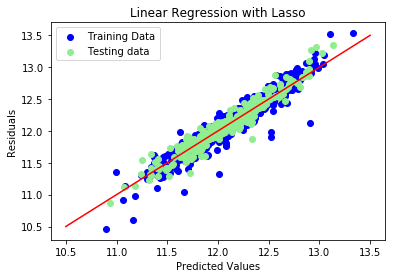

In [171]:
# How does prediction compare to actual data?
plt.scatter(y_train_lass, y_train, c="blue", marker="o", label="Training Data")
plt.scatter(y_test_lass, y_test, c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Lasso")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], color = "red")
plt.show()

In [172]:
print("Lasso picked " + str(sum(coefs_lasso != 0)) + " features and eliminated the other " +  \
      str(sum(coefs_lasso == 0)) + " features")
# Picked 113 features and eliminated 132 features

Lasso picked 84 features and eliminated the other 135 features


### ElasticNet

In [173]:
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 50000, cv = 10)

elasticNet.fit(x_train, y_train)

alpha_elas = elasticNet.alpha_

y_train_elas = elasticNet.predict(x_train)
y_test_elas = elasticNet.predict(x_test)

In [174]:
rmse_test(elasticNet).mean()

0.10835365700541408

In [175]:
r2_score(y_test, y_test_elas)

0.93069947280579357

In [176]:
adj_rsquared(r2_score(y_test, y_test_elas), data)

0.91506938479803746

In [177]:
mean_squared_error(y_test, y_test_elas)

0.010990049446281767

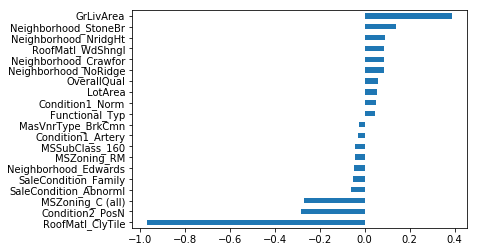

In [179]:
# What are the important coefficients?
coefs_elas = pd.Series(elasticNet.coef_, index=x_train.columns)
import_coefs_elas = pd.concat([coefs_elas.sort_values().head(10), coefs_elas.sort_values().tail(10)])
import_coefs_elas.plot(kind='barh')

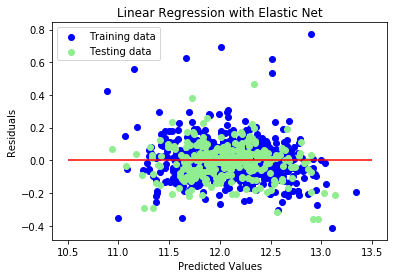

In [180]:
# What do residuals look like?
plt.scatter(y_train_elas, (y_train_elas - y_train), c="blue", marker="o", label = "Training data")
plt.scatter(y_test_elas, (y_test_elas - y_test), c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Elastic Net")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

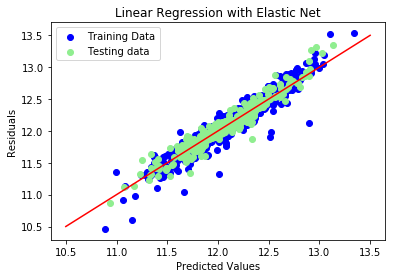

In [181]:
# How does prediction compare to actual data?
plt.scatter(y_train_elas, y_train, c="blue", marker="o", label="Training Data")
plt.scatter(y_test_elas, y_test, c="lightgreen", marker="o", label = "Testing data")
plt.title("Linear Regression with Elastic Net")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], color = "red")
plt.show()

In [182]:
print("Elastic Net picked " + str(sum(coefs_elas != 0)) + " features and eliminated the other " +  \
      str(sum(coefs_elas == 0)) + " features")

Elastic Net picked 85 features and eliminated the other 134 features


Elastinet has very similar results to Lasso